# Import Libraries

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [2]:
from choices import param_dict 
from utilities import deets

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938


In [6]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

# Load data

In [23]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


# Classification

## Cross validation

In [4]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight

### Train Classifier One Vs Rest

In [10]:
gamma = 0.07
cl_weight = calc_weight(gamma , y)
clf = lgb.LGBMClassifier(n_estimators = 100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model = make_model('lightGBM' , clf ,gamma , x,y)
model.validate(k=20)
model.train()

>>> GOING for 1 / 20 Iteration FOLD
>>> GOING for 2 / 20 Iteration FOLD
>>> GOING for 3 / 20 Iteration FOLD
>>> GOING for 4 / 20 Iteration FOLD
>>> GOING for 5 / 20 Iteration FOLD
>>> GOING for 6 / 20 Iteration FOLD
>>> GOING for 7 / 20 Iteration FOLD
>>> GOING for 8 / 20 Iteration FOLD
>>> GOING for 9 / 20 Iteration FOLD
>>> GOING for 10 / 20 Iteration FOLD
>>> GOING for 11 / 20 Iteration FOLD
>>> GOING for 12 / 20 Iteration FOLD
>>> GOING for 13 / 20 Iteration FOLD
>>> GOING for 14 / 20 Iteration FOLD
>>> GOING for 15 / 20 Iteration FOLD
>>> GOING for 16 / 20 Iteration FOLD
>>> GOING for 17 / 20 Iteration FOLD
>>> GOING for 18 / 20 Iteration FOLD
>>> GOING for 19 / 20 Iteration FOLD
>>> GOING for 20 / 20 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.977453 |          0.970966 |   0.974199 |
| CV      |       0.53012  |          0.598639 |   0.5623   |
| HMXB    |       0.9

In [30]:
model.result['res_table'].to_csv('temp_res_comp/train_prob/none_lightGBM.csv')

In [12]:
#model.train()
model.save('models/lightGBM-final.pkl')

## Prediction on New sources

In [7]:
import joblib 
model = joblib.load('models/lightGBM-final.pkl')
clf = model.clf

In [8]:
# u = []
# ui = []
# for i in range(8):
#     u.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/x-chunk-{i}.csv' , index_col='name'))
#     ui.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/id-chunk-{i}.csv' , index_col='name'))
# u = pd.concat(u)
# ui = pd.concat(ui)
ui = pd.read_csv('compiled_data_v3/id_frame-unid-var-src.csv' , index_col='name')
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
u

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J004829.5-732959,2.560959,8.422809,NaN,NaN,2.363359,NaN,9.949403,0.0,3.304254e-09,0.002147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J005449.0-725128,2.525176,8.405124,NaN,NaN,0.900227,NaN,1.221561,0.0,4.201018e-07,0.011944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010049.1-731526,2.548291,8.388764,NaN,NaN,2.694112,NaN,4.333967,0.0,8.611031e-08,0.003832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010049.8-731045,2.543942,8.388578,NaN,NaN,3.098912,NaN,3.680766,0.0,1.742587e-06,0.009243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010647.7-730940,2.544536,8.371916,NaN,NaN,9.693387,NaN,9.994160,6.0,5.241312e-08,0.003135,...,7.329417,3.418280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,2.153631,9.602391,6.284069,0.008090,0.848783,5.00,9.398184,0.0,2.267642e-07,0.035677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220508.3-495935,2.148799,9.600738,7.232708,0.007515,7.897757,6.25,9.373067,2.0,8.028243e-08,0.041673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220544.0-495505,2.142337,9.602388,7.905990,0.007822,NaN,6.25,NaN,NaN,1.863801e-07,0.016260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J004829.5-732959,0.006866,0.003271,0.854534,0.000017,0.002261,0.115568,0.017461,0.000021
2CXO J005449.0-725128,0.008875,0.016311,0.929717,0.000043,0.000785,0.043891,0.000347,0.000032
2CXO J010049.1-731526,0.008277,0.004818,0.807098,0.000054,0.005160,0.167167,0.007402,0.000025
2CXO J010049.8-731045,0.040766,0.016721,0.526201,0.000443,0.003861,0.407359,0.004558,0.000092
2CXO J010647.7-730940,0.004241,0.009808,0.683742,0.002000,0.008044,0.291919,0.000168,0.000077
...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,0.032561,0.233294,0.671695,0.000025,0.000336,0.007829,0.054160,0.000100
2CXO J220508.3-495935,0.017150,0.063122,0.913425,0.000210,0.000860,0.001775,0.003403,0.000054
2CXO J220544.0-495505,0.089127,0.091377,0.801407,0.000579,0.000613,0.013682,0.003008,0.000208
2CXO J220555.6-500837,0.000871,0.008760,0.926816,0.000044,0.000296,0.000558,0.062627,0.000027


In [10]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,0.854534,0.738966,0.006866,0.003271,0.854534,0.000017,0.002261,0.115568,0.017461,0.000021
2CXO J005449.0-725128,HMXB,0.929717,0.885827,0.008875,0.016311,0.929717,0.000043,0.000785,0.043891,0.000347,0.000032
2CXO J010049.1-731526,HMXB,0.807098,0.639931,0.008277,0.004818,0.807098,0.000054,0.005160,0.167167,0.007402,0.000025
2CXO J010049.8-731045,HMXB,0.526201,0.118842,0.040766,0.016721,0.526201,0.000443,0.003861,0.407359,0.004558,0.000092
2CXO J010647.7-730940,HMXB,0.683742,0.391823,0.004241,0.009808,0.683742,0.002000,0.008044,0.291919,0.000168,0.000077
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.671695,0.438401,0.032561,0.233294,0.671695,0.000025,0.000336,0.007829,0.054160,0.000100
2CXO J220508.3-495935,HMXB,0.913425,0.850303,0.017150,0.063122,0.913425,0.000210,0.000860,0.001775,0.003403,0.000054
2CXO J220544.0-495505,HMXB,0.801407,0.710030,0.089127,0.091377,0.801407,0.000579,0.000613,0.013682,0.003008,0.000208


In [44]:
u_df.to_csv('temp_res_comp/unid_prob/lightGBM_none.csv')

In [47]:
u_df = pd.read_csv('temp_res_comp/unid_prob/lightGBM_none.csv' , index_col='name')
u_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,0.854534,0.738966,0.006866,0.003271,0.854534,0.000017,0.002261,0.115568,0.017461,0.000021
2CXO J005449.0-725128,HMXB,0.929717,0.885827,0.008875,0.016311,0.929717,0.000043,0.000785,0.043891,0.000347,0.000032
2CXO J010049.1-731526,HMXB,0.807098,0.639931,0.008277,0.004818,0.807098,0.000054,0.005160,0.167167,0.007402,0.000025
2CXO J010049.8-731045,HMXB,0.526201,0.118842,0.040766,0.016721,0.526201,0.000443,0.003861,0.407359,0.004558,0.000092
2CXO J010647.7-730940,HMXB,0.683742,0.391823,0.004241,0.009808,0.683742,0.002000,0.008044,0.291919,0.000168,0.000077
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.671695,0.438401,0.032561,0.233294,0.671695,0.000025,0.000336,0.007829,0.054160,0.000100
2CXO J220508.3-495935,HMXB,0.913425,0.850303,0.017150,0.063122,0.913425,0.000210,0.000860,0.001775,0.003403,0.000054
2CXO J220544.0-495505,HMXB,0.801407,0.710030,0.089127,0.091377,0.801407,0.000579,0.000613,0.013682,0.003008,0.000208


In [11]:
u_pos = pd.merge(u_df[['class','prob']] , ui[['ra','dec']] ,left_index=True,right_index=True)
u_pos

,class,prob,ra,dec
name,,,,
2CXO J004829.5-732959,HMXB,0.854534,12.123114,-73.499901
2CXO J005449.0-725128,HMXB,0.929717,13.704345,-72.857987
2CXO J010049.1-731526,HMXB,0.807098,15.204787,-73.257463
2CXO J010049.8-731045,HMXB,0.526201,15.207831,-73.179381
2CXO J010647.7-730940,HMXB,0.683742,16.699164,-73.161175
...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.671695,331.138121,-49.987838
2CXO J220508.3-495935,HMXB,0.913425,331.284642,-49.993301
2CXO J220544.0-495505,HMXB,0.801407,331.433541,-49.918280


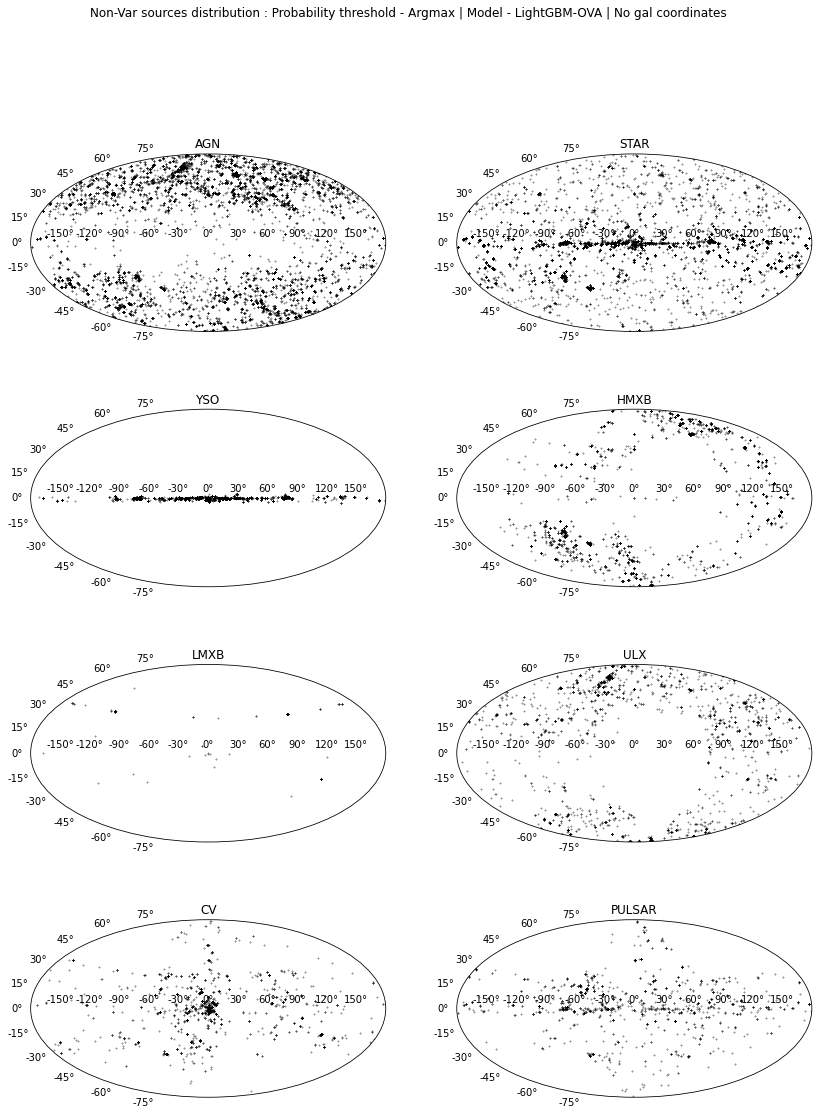

In [12]:
from astropy.coordinates import SkyCoord
from astropy import units as unit 
# plt.figure(figsize=(12,10))
# plt.subplot(111, projection='aitoff' ,)
# plt.grid(True)
colors =['black','lightcoral','lime','fuchsia', 'teal' , 'gold' , 'crimson' , 'indigo']
#fig , ax = plt.subplots(nrows=2, ncols=4 , figsize=(16,10) , projection='aitoff' ,)
k = 0
#cl = np.reshape(classes , ax.shape)
fig = plt.figure(figsize=(14, 18))
for i in range(1,9):
    #cl = classes[k]
    df_plot = u_pos[u_pos['class']==classes[i-1]]
    prob_th = 0.
    df_plot = df_plot[df_plot['prob']>prob_th]
    eq = SkyCoord(df_plot['ra'] , df_plot['dec'] , unit = unit.deg)
    gal = eq.galactic
    ax = fig.add_subplot(int(f'42{i}') , projection='aitoff')
    ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian , s=1 , marker='x',alpha=0.4 , label=classes[i-1] , color='k')
    ax.set_title(classes[i-1])
    #plt.legend()
fig.suptitle('Non-Var sources distribution : Probability threshold - Argmax | Model - LightGBM-OVA | No gal coordinates')
#plt.savefig('plots/all_src_pred/lightgbm_non-var.jpg')
plt.show()

In [24]:
u_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,0.854534,0.738966,0.006866,0.003271,0.854534,0.000017,0.002261,0.115568,0.017461,0.000021
2CXO J005449.0-725128,HMXB,0.929717,0.885827,0.008875,0.016311,0.929717,0.000043,0.000785,0.043891,0.000347,0.000032
2CXO J010049.1-731526,HMXB,0.807098,0.639931,0.008277,0.004818,0.807098,0.000054,0.005160,0.167167,0.007402,0.000025
2CXO J010049.8-731045,HMXB,0.526201,0.118842,0.040766,0.016721,0.526201,0.000443,0.003861,0.407359,0.004558,0.000092
2CXO J010647.7-730940,HMXB,0.683742,0.391823,0.004241,0.009808,0.683742,0.002000,0.008044,0.291919,0.000168,0.000077
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.671695,0.438401,0.032561,0.233294,0.671695,0.000025,0.000336,0.007829,0.054160,0.000100
2CXO J220508.3-495935,HMXB,0.913425,0.850303,0.017150,0.063122,0.913425,0.000210,0.000860,0.001775,0.003403,0.000054
2CXO J220544.0-495505,HMXB,0.801407,0.710030,0.089127,0.091377,0.801407,0.000579,0.000613,0.013682,0.003008,0.000208


In [28]:
u_df_num = u_df['class'].value_counts().to_frame()
u_df_num = pd.concat([
                u_df['class'].value_counts() ,
                #u_df[u_df['prob']>mode]['class'].value_counts(),
                u_df[u_df['prob']>0.5]['class'].value_counts(),
                #u_df[u_df['prob']>0.6]['class'].value_counts(),
                #u_df[u_df['prob']>0.7]['class'].value_counts(),
                u_df[u_df['prob']>0.8]['class'].value_counts(),
                #u_df[u_df['prob']>0.9]['class'].value_counts(),
                u_df[u_df['prob']>0.98]['class'].value_counts(),
                 ] , axis=1)
u_df_num.columns = ['Argmax'  ,'0.5' , '0.8'  ,  f"0.98"]
u_df_num.index.name = 'class'
#u_df_num.to_csv(f'temp_res_comp/unid_num/{d_name}_{m_name}.csv')
u_df_num.append(u_df_num.sum() , ignore_index=True)
print(u_df_num.to_markdown())

| class   |   Argmax |   0.5 |   0.8 |   0.98 |
|:--------|---------:|------:|------:|-------:|
| AGN     |    11250 | 10661 |  8638 |   5627 |
| STAR    |    10585 | 10173 |  8262 |   5878 |
| YSO     |     9027 |  8896 |  7387 |   4041 |
| HMXB    |     3289 |  2914 |  1846 |    857 |
| ULX     |     2318 |  2004 |  1078 |    242 |
| CV      |     1841 |  1505 |   778 |    205 |
| PULSAR  |     1396 |  1095 |   512 |     84 |
| LMXB    |      187 |   181 |   165 |    137 |


In [29]:
print(u_df_num.to_latex(bold_rows=True))

\begin{tabular}{lrrrr}
\toprule
{} &  Argmax &    0.5 &   0.8 &  0.98 \\
\textbf{class } &         &        &       &       \\
\midrule
\textbf{AGN   } &   11250 &  10661 &  8638 &  5627 \\
\textbf{STAR  } &   10585 &  10173 &  8262 &  5878 \\
\textbf{YSO   } &    9027 &   8896 &  7387 &  4041 \\
\textbf{HMXB  } &    3289 &   2914 &  1846 &   857 \\
\textbf{ULX   } &    2318 &   2004 &  1078 &   242 \\
\textbf{CV    } &    1841 &   1505 &   778 &   205 \\
\textbf{PULSAR} &    1396 &   1095 &   512 &    84 \\
\textbf{LMXB  } &     187 &    181 &   165 &   137 \\
\bottomrule
\end{tabular}



In [17]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
#cl.remove('LMXB')
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
#fig.write_image('temp_res_comp/unid_prob_dist/lightGBM_none.jpg')
fig.show()

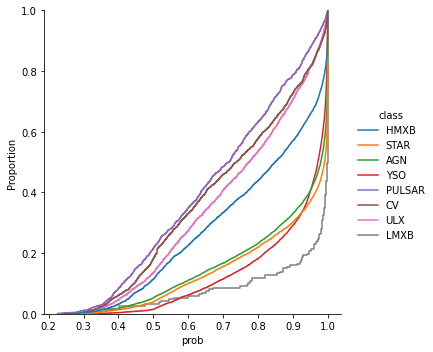

In [18]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()

In [19]:
u_conf = u[u_df['prob']>0.98]
u_conf

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J011132.4-730210,2.539434,8.358207,NaN,NaN,0.687469,NaN,0.686607,0.0,1.049425e-04,0.060486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.743586,3.966770,5.344862
2CXO J012106.5-730352,2.546208,8.331692,NaN,NaN,0.881629,NaN,9.173512,0.0,1.539318e-07,0.067567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.476278,3.162538,5.380952
2CXO J165038.2-433554,5.026490,9.491185,NaN,NaN,9.469891,NaN,9.807162,6.0,3.676157e-08,0.013108,...,7.632290,4.226298,3.921825,NaN,4.731816,NaN,9.896374,4.931906,NaN,NaN
2CXO J171052.0-393315,4.999021,9.644353,NaN,NaN,9.480754,NaN,9.999759,6.0,NaN,0.008154,...,5.695557,3.888696,2.846068,3.159264,3.115610,5.084363,9.850756,3.556724,3.615961,4.791479
2CXO J171104.3-393951,4.993618,9.642535,NaN,NaN,10.000000,NaN,10.000000,9.0,7.876697e-08,0.025182,...,8.181465,4.926246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J060212.5-395227,3.546104,6.844886,5.975523,0.000653,9.864978,5.00,9.984111,6.0,8.236682e-09,0.001646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.506049,NaN,NaN
2CXO J060228.9-400246,3.546502,6.850436,6.907320,0.001225,10.000000,6.25,10.000000,9.0,2.192449e-09,0.007383,...,6.002884,5.485637,3.811712,NaN,4.436957,NaN,9.863985,3.424970,NaN,NaN
2CXO J060233.7-395610,3.548883,6.847263,9.888299,0.002254,10.000000,7.50,10.000000,9.0,2.711781e-09,0.007225,...,5.102440,4.712172,3.272828,NaN,3.749833,NaN,9.856465,3.511750,NaN,NaN


In [70]:
y

array([0.22552117, 0.24101072, 0.25650027, 0.27198982, 0.28747937,
       0.30296893, 0.31845848, 0.33394803, 0.34943758, 0.36492713,
       0.38041668, 0.39590623, 0.41139579, 0.42688534, 0.44237489,
       0.45786444, 0.47335399, 0.48884354, 0.50433309, 0.51982265,
       0.5353122 , 0.55080175, 0.5662913 , 0.58178085, 0.5972704 ,
       0.61275995, 0.6282495 , 0.64373906, 0.65922861, 0.67471816,
       0.69020771, 0.70569726, 0.72118681, 0.73667636, 0.75216592,
       0.76765547, 0.78314502, 0.79863457, 0.81412412, 0.82961367,
       0.84510322, 0.86059278, 0.87608233, 0.89157188, 0.90706143,
       0.92255098, 0.93804053, 0.95353008, 0.96901963, 0.98450919,
       0.99999874])

In [30]:
y_p = u_df['class']
cl = ['AGN' ,'STAR' , 'YSO' , 'HMXB' , 'LMXB' , 'ULX' ,'CV' ,'PULSAR']
sns.set(font_scale=1.2, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':False} , style="ticks")
f = 'kp_intra_prob_b'
f = 'var_inter_prob_b'
fig , ax = plt.subplots(nrows=4, ncols=2 , figsize=(12,14) , sharex=True)
#plt.hist(x['kp_intra_prob_b'])
cl = np.reshape(cl , ax.shape)
for i in range(4):
    for j in range(2):
        temp = u[y_p==cl[i][j]]
        ax[i][j].hist(temp[f] , label = 'Unidentified sources' , color='crimson' , )
        temp = x[y==cl[i][j]]
        #display(temp)
        ax[i][j].hist(temp[f] , label = 'Training sources' , color='black', )
        ax[i][j].set_title(cl[i][j])
        ax[i][j].legend()
        #ax[i][j].set_xlabel('var_intra_prob_b')
ax[3][0].set_xlabel(f)
ax[3][1].set_xlabel(f)

#plt.savefig('final_plots/var-src-hist.eps' , format='eps')
plt.show()

In [21]:
u_df[u_df['prob']>0.9]['class'].value_counts()

AGN       7541
STAR      7387
YSO       6399
HMXB      1412
ULX        678
CV         504
PULSAR     295
LMXB       157
Name: class, dtype: int64

In [22]:

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
upie = u_df[u_df['prob']>0.98]['class'].value_counts().to_dict()
xpie = y.value_counts().to_dict()
fig  , ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
ax1 = plt.subplot(121)
ax1.bar(upie.keys() ,upie.values()) 
ax2 = plt.subplot(122)
ax2.bar(xpie.keys() ,xpie.values()) 
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [102]:
u_df_conf = u_df[u_df['prob']>0.98]

In [144]:
t = y.value_counts().to_frame(name='train')
u = u_df_conf['class'].value_counts().to_frame(name='unid')
data = pd.concat([t,u], axis=1)
data.index.name = 'class'
data

,train,unid
class,,
STAR,2790,5878
AGN,2395,5627
YSO,1149,4041
HMXB,748,857
ULX,211,242
CV,166,205
LMXB,143,137
PULSAR,101,84


In [166]:
            
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = 'white'
color_red = 'crimson'
color_blue = 'k'
index = data.index
column0 = data['train']
column1 = data['unid']
title0 = 'Training Sources'
title1 = 'Unidentified sources'

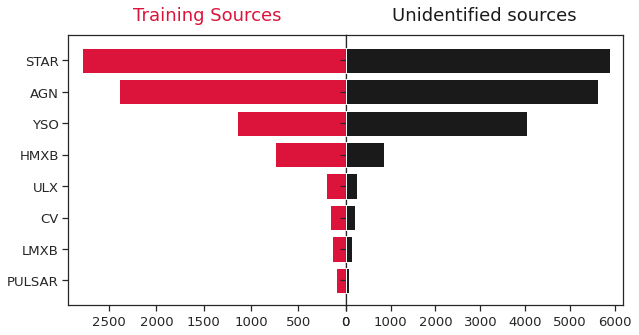

In [169]:

              
fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()          
axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)
axes[0].invert_xaxis() 
plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
plt.savefig('final_plots/var-src-num.eps' , format='eps')
plt.show()